# Cosyne 2020 Tutorial by Ann Hermundstad

Sashank Pisupati, 02/20/20


This notebook contains simulations of the problem set from the 2020 Cosyne Tutorial on normative modeling. It is divided into 3 parts:
1. Sensory coding: simulate spike count distributions for various sensory tuning functions, and optimize the tuning function to maximize entropy
2. Inferring context: simulate online inference of context from noisy sensory samples
3. Selecting actions: simulate foraging on a patch for various policies and learning rules

# 1. Problem setup
First, let us setup some machinery that will let us custom define the bee's environment

In [1]:
# Import relevant modules
import re
import numpy as np
import scipy.stats as ss
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

# Setup environment with user-defined parameters (means & standard deviations)
class createEnv:
    def __init__(self,pFlowerMu,pFlowerSig):
        self.pFlowerMu = pFlowerMu
        self.pFlowerSig = pFlowerSig
            
    # Probability density of flower frequencies in "field" or "forest" environments
    def pFlower(self,f,context):
        if context == 'both':
            return 0.5*ss.norm.pdf(f,loc = self.pFlowerMu['field'], scale = self.pFlowerSig['field']) + 0.5*ss.norm.pdf(f,loc = self.pFlowerMu['forest'], scale = self.pFlowerSig['forest'])
        else:
            return ss.norm.pdf(f,loc = self.pFlowerMu[context], scale = self.pFlowerSig[context])
        
    # Cumulative density of flower frequencies in "field" or "forest" environments
    def cFlower(self,f,context):
        if context == 'both':
            return 0.5*ss.norm.cdf(f,loc = self.pFlowerMu['field'], scale = self.pFlowerSig['field']) + 0.5*ss.norm.cdf(f,loc = self.pFlowerMu['forest'], scale = self.pFlowerSig['forest'])
        else:
            return ss.norm.cdf(f,loc = self.pFlowerMu[context], scale = self.pFlowerSig[context])
        
    # Randomly sample a flower frequency from a given context
    def sample(self,context,n=1):
        return ss.norm.rvs(loc = self.pFlowerMu[context], scale = self.pFlowerSig[context],size = n)
        

### Contexts with different means
Now let's create an environment where fields and forests differ in the average color (i.e. frequency of light) of flowers

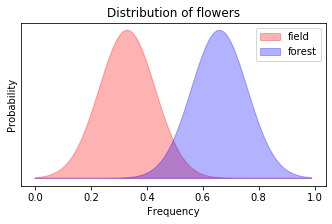

In [2]:
### Create an environment with different mean frequency in fields and forests (but same variance)
env = createEnv(pFlowerMu = {'field': 0.33, 'forest': 0.66} ,pFlowerSig = {'field': 0.1, 'forest': 0.1})


# Plot distribution of flowers in the two contexts
f = np.arange(0,1,0.01)
plt.figure(figsize=(12, 3))
plt.subplot(121,title = 'Distribution of flowers')
colors = {'forest':[0,0,1],'field':[1,0,0]}
for context in {'forest','field'}:
    plt.fill(np.concatenate(([0],f,[f[-1]])),np.concatenate(([0],env.pFlower(f,context),[0])),alpha = 0.3,color = colors[context],label = context)
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('Probability')
plt.yticks([])

plt.show()


# 2. Sensory coding
Let us create a bee with a "frequency detector" neuron that encodes sensory information into spike counts using a nonlinear tuning function

In [3]:
# Frequency tuning function
def tuningFun(f,beePars):
    rate = beePars['kMax']*ss.norm.cdf(f, beePars['tuningOffset'],1/beePars['tuningSlope']); # Cumulative normal tuning
    counts = np.round(rate);
    return rate,counts

# Spike count probability
def spikeProb(f,beePars, env, context):
    # First, get spike counts as a function of f
    rate,counts = tuningFun(f,beePars)
    cbin = np.unique(counts)
    
    # Next, get unique frequency bins using inverse tuning function
    fbin = ss.norm.ppf([counts/beePars['kMax'],(counts-1)/beePars['kMax']],loc = beePars['tuningOffset'],scale = 1/beePars['tuningSlope'])
    fbin[np.isnan(fbin)]=0
    fbin[np.logical_and(np.isinf(fbin),fbin>0)]=1
    fbin[fbin<0]=0
    fbin=np.unique(fbin,axis = 1)
    
    # Finally, get probability mass in each bin
    pbin = env.cFlower(fbin[0][:],context)-env.cFlower(fbin[1][:],context)
    pbin = pbin/np.sum(pbin)
    return cbin,pbin


You can play around with the tuning function's parameters, noticing how they change the distribution of spike counts in different contexts

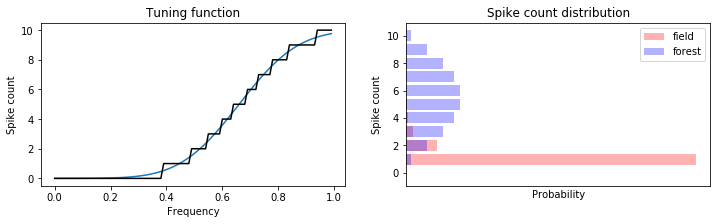

In [4]:
### Set parameters of bee sensory neuron's tuning function
beePars = {'kMax': 10, 'tuningOffset': 0.66,'tuningSlope': 6}


# Plot tuning function
plt.figure(figsize=(12, 3))
plt.subplot(121,title = 'Tuning function')
rate,counts = tuningFun(f,beePars)
plt.plot(f,rate)
plt.plot(f,counts,color = 'k')
plt.xlabel('Frequency')
plt.ylabel('Spike count')

# Plot spike count distribution
plt.subplot(122,title = 'Spike count distribution')
for context in {'forest','field'}:
    counts, prob = spikeProb(f,beePars,env,context)
    plt.barh(counts,prob,color = colors[context],alpha= 0.3,label = context)
plt.ylabel('Spike count')
plt.xticks([])
plt.xlabel('Probability')
plt.legend()

plt.show()

## Optimizing sensory tuning
Let's try to optimize the parameters of the tuning function in order to:
1.  Maximize entropy of the spike count distribution in forests
2.  Maximize entropy of the spike count distribution for both forests & fields

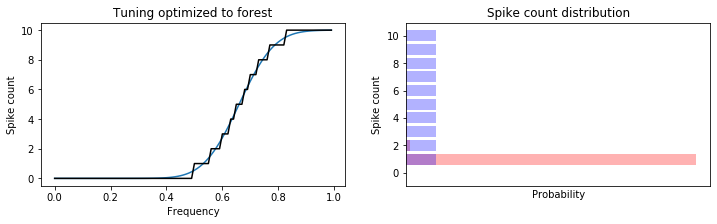

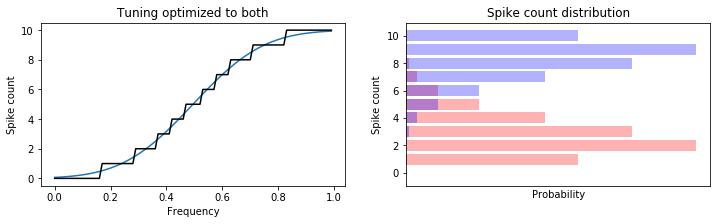

In [5]:
# Calculate the (negative) entropy of the spike count distribution
def spikeNegEntropy(params, f,kMax, env, context):
    # Tuning parameters
    pars = {}
    pars['kMax'] = kMax
    pars['tuningOffset'] = params[0]
    pars['tuningSlope'] = params[1]
    
    # Spike count distribution for this set of parameters
    counts, prob = spikeProb(f,pars,env,context)
    
    # (Negative) entropy of encoding
    return sum(np.multiply(prob[prob>0],np.log2(prob[prob>0])))  


# Maximize entropy in forests/both forests & fields
beeParsMaxEnt = {'forest':{},'both':{}}
for context in beeParsMaxEnt:
    # Find tuning parameters that minimize negative entropy in this context
    result = opt.minimize(spikeNegEntropy,[0.5,5],args = (f,beePars['kMax'],env,context))
    beeParsMaxEnt[context]['kMax'] = beePars['kMax']
    beeParsMaxEnt[context]['tuningOffset'] = result.x[0] 
    beeParsMaxEnt[context]['tuningSlope'] = result.x[1] 
    
    # Plot optimal tuning function
    fig = plt.figure(figsize=(12, 3))
    fig.add_subplot(1,2,1,title = 'Tuning optimized to '+context)
    rate,counts = tuningFun(f,beeParsMaxEnt[context])
    plt.plot(f,rate)
    plt.plot(f,counts,color = 'k')
    plt.xlabel('Frequency')
    plt.ylabel('Spike count')

    # Plot spike count distribution
    fig.add_subplot(1,2,2,title = 'Spike count distribution')
    for c in {'forest','field'}:
        counts, prob = spikeProb(f,beeParsMaxEnt[context],env,c)
        plt.barh(counts,prob,color = colors[c],alpha= 0.3,label = c)
    plt.ylabel('Spike count')
    plt.xticks([])
    plt.xlabel('Probability')
    
    plt.show()
    

### Contexts with different variances
Let's see what happens to the optimal tuning if forests and fields had the same mean frequency, but different variances 

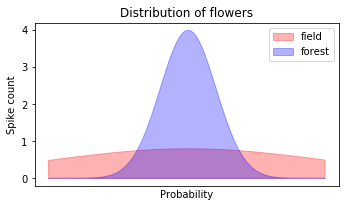

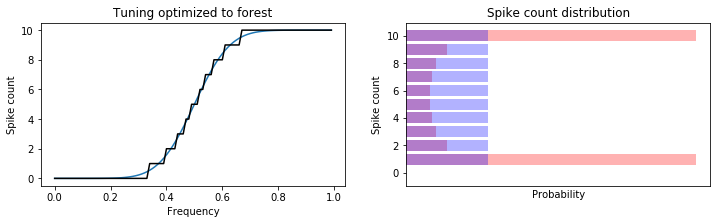

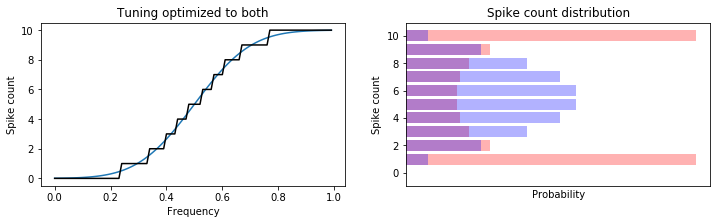

In [6]:
### Create an environment with different mean frequency in fields and forests (but same variance)
env = createEnv(pFlowerMu = {'field': 0.5, 'forest': 0.5} ,pFlowerSig = {'field': 0.5, 'forest': 0.1})


# Plot distribution of flowers
fig1 = plt.figure(figsize=(12, 3))
fig1.add_subplot(1,2,1,title = 'Distribution of flowers')
for context in {'forest','field'}:
    plt.fill(np.concatenate(([0],f,[f[-1]])),np.concatenate(([0],env.pFlower(f,context),[0])),alpha = 0.3,color = colors[context],label = context)
plt.ylabel('Spike count')
plt.xticks([])
plt.xlabel('Probability')
plt.legend()
plt.show()

# Maximize entropy in forests/both forests & fields
beeParsMaxEnt = {'forest':{},'both':{}}
for context in beeParsMaxEnt:
    # Find tuning parameters that minimize negative entropy in this context
    result = opt.minimize(spikeNegEntropy,[0.5,5],args = (f,beePars['kMax'],env,context))
    beeParsMaxEnt[context]['kMax'] = beePars['kMax']
    beeParsMaxEnt[context]['tuningOffset'] = result.x[0] 
    beeParsMaxEnt[context]['tuningSlope'] = result.x[1] 
    
    # Plot optimal tuning function
    fig = plt.figure(figsize=(12, 3))
    fig.add_subplot(1,2,1,title = 'Tuning optimized to '+context)
    rate,counts = tuningFun(f,beeParsMaxEnt[context])
    plt.plot(f,rate)
    plt.plot(f,counts,color = 'k')
    plt.xlabel('Frequency')
    plt.ylabel('Spike count')
    
    # Plot spike count distribution
    fig.add_subplot(1,2,2,title = 'Spike count distribution')
    for c in {'forest','field'}:
        counts, prob = spikeProb(f,beeParsMaxEnt[context],env,c)
        plt.barh(counts,prob,color = colors[c],alpha= 0.3,label = c)
    plt.ylabel('Spike count')
    plt.xticks([])
    plt.xlabel('Probability')
    
    plt.show()

# 3. Inferring context
Let's set up the context switching dynamics of the environment

In [7]:
# Setup dynamics with user-defined environment & parameters
class simulateEnv:
    def __init__(self,env,dynPars):
        self.env = env
        self.dynPars = dynPars
       
    #Sample contexts, observed flower frequencies
    def sample(self):
        fObs = np.zeros(self.dynPars['tMax'])
        pSwitch = 1/self.dynPars['nSwitch'] # Hazard rate i.e. 1/(avg no. encounters before switching contexts)
        contextFlag = np.zeros(self.dynPars['tMax'],dtype='int')
        contextLabel = list(env.pFlowerMu.keys())
        
        # Regularly switching contexts
        if self.dynPars['type'] == 'regular':
            # Start from 'field' context, sample frequencies
            fObs = self.env.sample(contextLabel[0],self.dynPars['tMax'])
            for i in np.arange(np.round(self.dynPars['tMax']*pSwitch/2)):
                    # Switch to 'forest' context every 'nSwitch' trials
                    inds = np.arange((2*i-1)*self.dynPars['nSwitch'],2*i*self.dynPars['nSwitch'],dtype='int')
                    contextFlag[inds]=1
                    # Sample flower frequencies from 'forest' context
                    fObs[inds] = self.env.sample(contextLabel[1],np.size(inds))
                    
        # Stochastically switching contexts
        elif self.dynPars['type'] == 'stochastic':
            # Start from 'field' context, sample frequencies
            fObs[0] = self.env.sample(contextLabel[0])
            for i in np.arange(1,self.dynPars['tMax'],dtype='int'):
                # Switch contexts with a probability of 'pSwitch'
                if np.random.rand()<pSwitch:
                    contextFlag[i] = not(contextFlag[i-1])
                else:
                    contextFlag[i] = contextFlag[i-1]
                # Sample flower frequencies from chosen context
                fObs[i] = self.env.sample(contextLabel[contextFlag[i]])
        return contextFlag,fObs
    

Now let's write a function to perform online inference as the bee encounters flowers in different contexts.
As a reminder, this involves two steps at each encounter:
1. Predicting the context based on the previous belief & knowledge about the dynamics, before observing a flower's color
2. Updating belief about context after observing the flower's color

In [8]:
# Perform online inference
def onlineInference(fObs,env,pSwitch=0.5,p0=[0.5,0.5]):
    
    # Construct transition matrix
    T = [[1-pSwitch,pSwitch],[pSwitch,1-pSwitch]]
    
    # Initialize beliefs
    pContext = np.zeros([2,np.size(fObs)])
    pContext[:,0] = p0
    contextLabel = list(env.pFlowerMu.keys())
    
    for t in np.arange(np.size(fObs)):
        #Prediction step
        if t>0:
            # Apply transition matrix
            pContext[:,t] = np.matmul(T,pContext[:,t-1])
        
        #Update step
        #Likelihood of observation fObs(t) under the two contexts
        lik = [env.pFlower(fObs[t],contextLabel[0]),env.pFlower(fObs[t],contextLabel[1])]
        #Posterior belief (normalized)
        pContext[:,t] = pContext[:,t]*lik
        pContext[:,t] = pContext[:,t]/sum(pContext[:,t])
        
    return pContext


### Contexts with different means
Let's go back to the environment where forests and fields had different mean frequencies, and simulate online inference. Let's assume that contexts reliably switch every 10 encounters, and run the simulations for 200 encounters, and plot the running posterior belief as well as the posterior belief averaged over switches.

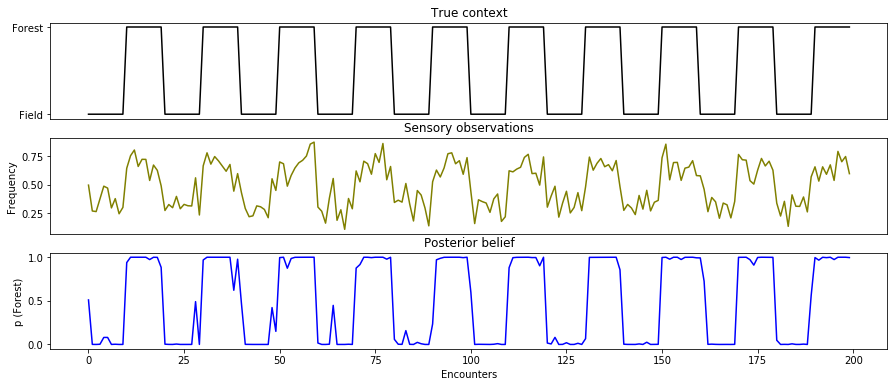

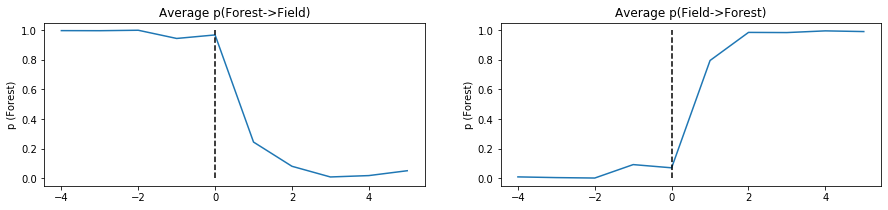

In [9]:
### Create an environment with different mean frequency in fields and forests 
env = createEnv(pFlowerMu = {'field': 0.33, 'forest': 0.66} ,pFlowerSig = {'field': 0.1, 'forest': 0.1})

### Simulate regular context switches every 10 trials, for 200 trials (Bonus: Try changing 'type' to stochastic)
sim = simulateEnv(env, dynPars = {'type': 'regular', 'tMax': 200, 'nSwitch': 10})

### Sample contexts, frequency samples from that context
contextFlag,fObs = sim.sample()
pContext = onlineInference(fObs,env,0.1)


# Plot true context, sensory observation & running posterior belief
fig1 = plt.figure(figsize=(15, 6))
plt.subplot(311,title = 'True context')
plt.plot(contextFlag,color = [0,0,0])
plt.xticks([])
plt.yticks([0,1],['Field','Forest'])
plt.subplot(312,title = 'Sensory observations')
plt.plot(fObs,color = [0.5,0.5,0])
plt.ylabel('Frequency')
plt.xticks([])
plt.subplot(313,title = 'Posterior belief')
plt.plot(pContext[1,:],color = [0,0,1])
plt.xlabel('Encounters')
plt.ylabel('p (Forest)')
plt.show()

# Plot posterior belief averaged over switches
pattern = {'Forest->Field':'1111100000', 'Field->Forest':'0000011111'}
fig2 = plt.figure(figsize=(15, 3))
k = 1
for s in pattern.keys():
    fig2.add_subplot(1,2,k,title = 'Average p('+s+')')
    k+=1
    pAvg = np.zeros(10)
    inds = [m.start() for m in re.finditer(pattern[s], ''.join(str(e) for e in contextFlag))]
    for i in inds:
        pAvg = pAvg + pContext[1,i:i+10]
    pAvg = pAvg/np.size(inds)
    plt.plot(np.arange(-4,6),pAvg)
    plt.ylabel('p (Forest)')
    plt.plot([0,0],[0,1],'k--')


### Contexts with different variances
Now let's do the same simulation in an environment where the two contexts have the same mean frequency, but different variances. 

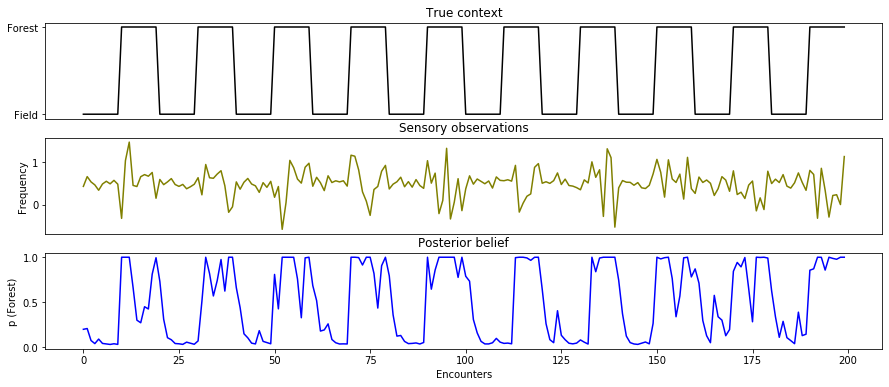

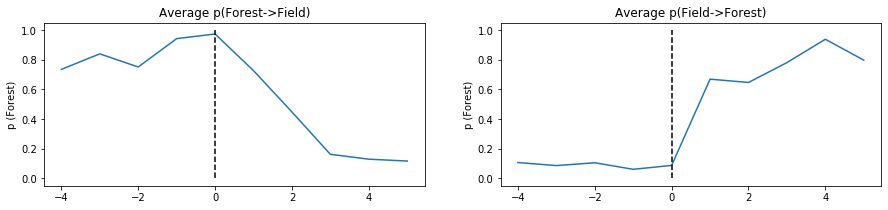

In [10]:
### Create an environment with different mean frequency in fields and forests 
env = createEnv(pFlowerMu = {'field': 0.5, 'forest': 0.5} ,pFlowerSig = {'field': 0.1, 'forest': 0.5})

### Simulate regular context switches every 10 trials, for 200 trials
sim = simulateEnv(env, dynPars = {'type': 'regular', 'tMax': 200, 'nSwitch': 10})

### Sample contexts, frequency samples from that context
contextFlag,fObs = sim.sample()
pContext = onlineInference(fObs,env,0.1)


# Plot true context, sensory observation & running posterior belief
fig1 = plt.figure(figsize=(15, 6))
plt.subplot(311,title = 'True context')
plt.plot(contextFlag,color = [0,0,0])
plt.xticks([])
plt.yticks([0,1],['Field','Forest'])
plt.subplot(312,title = 'Sensory observations')
plt.plot(fObs,color = [0.5,0.5,0])
plt.ylabel('Frequency')
plt.xticks([])
plt.subplot(313,title = 'Posterior belief')
plt.plot(pContext[1,:],color = [0,0,1])
plt.xlabel('Encounters')
plt.ylabel('p (Forest)')
plt.show()

# Plot posterior belief averaged over switches
pattern = {'Forest->Field':'1111100000', 'Field->Forest':'0000011111'}
fig2 = plt.figure(figsize=(15, 3))
k = 1
for s in pattern.keys():
    fig2.add_subplot(1,2,k,title = 'Average p('+s+')')
    k+=1
    pAvg = np.zeros(10)
    inds = [m.start() for m in re.finditer(pattern[s], ''.join(str(e) for e in contextFlag))]
    for i in inds:
        pAvg = pAvg + pContext[1,i:i+10]
    pAvg = pAvg/np.size(inds)
    plt.plot(np.arange(-4,6),pAvg)
    plt.ylabel('p (Forest)')
    plt.plot([0,0],[0,1],'k--')


# 4. Selecting actions
Let's turn now to simulating actions of the bee in this environment. First, let's setup a 2d patch with varying flower frequencies for the bee to forage in

In [11]:
class createPatch:
    # Create 2d flower frequency pattern
    def __init__(self):
        X,Y = np.meshgrid(np.linspace(-3,3,100),np.linspace(-3,3,100))
        F = -(X**5-Y**5-2*np.matmul(X,Y)-2*X**3-3*Y**3)*(1.1*np.exp(-0.4*(X-1.5)**2-0.5*(Y-1.5)**2)-0.7*np.exp(-(X+2)**2-(Y+2)**2-0.8*(X+2)*(Y+2))-0.7*np.exp(-(X+2)**2-0.5*(Y-2)**2+0.3*(X+2)*(Y-2))-0.5*np.exp(-3*(X-2)**6-4*(Y+2)**2+4*(X-2)*(Y+2)**2));
        F = 1-(F- np.min(F))/(np.max(F)-np.min(F));
        self.X = X
        self.Y = Y
        self.F = F
    
     # Frequency as a function of location on patch
    def f(self,xCurr,yCurr,xNext,yNext):
        iCurr = np.max(np.where(patch.X<xCurr)[1])
        jCurr = np.max(np.where(patch.Y<yCurr)[0])
        iNext = np.max(np.where(patch.X<xNext)[1])
        jNext = np.max(np.where(patch.Y<yNext)[0])
        return self.F[iCurr,jCurr], self.F[iNext,jNext]
    
     # Nectar as a function of frequency in "field" or "forest" environments
    def nectar(self,f,context):
        if context =='field':
            return 1-ss.norm.cdf(f, loc = 0.5,scale = 0.15)
        elif context =='forest':
            return ss.norm.cdf(f, loc = 0.5,scale = 0.15)


Let's take a look at this patch, and the available nectar in different contexts

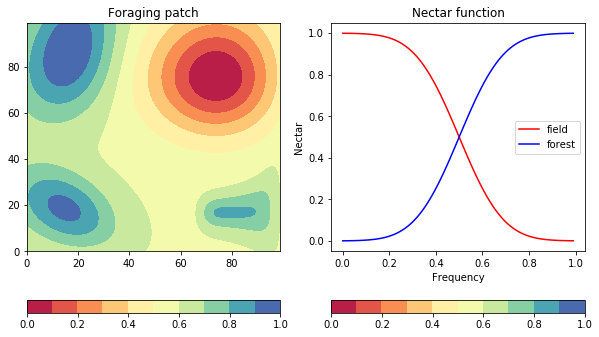

In [12]:
### Create a patch for the bee to forage in 
patch = createPatch()

# Plot flower frequency patterns in patch
plt.figure(figsize=(10, 6))
plt.subplot(121,title = 'Foraging patch')
plt.contourf(patch.F,levels=10,cmap=plt.cm.get_cmap('Spectral'))
plt.colorbar(orientation = 'horizontal')

# Plot nectar function in the two contexts
plt.subplot(122,title = 'Nectar function')
for context in {'forest','field'}:
    plt.plot(f,patch.nectar(f,context),color = colors[context],label = context)
plt.xlabel('Frequency')
plt.ylabel('Nectar')
plt.legend()
plt.colorbar(orientation = 'horizontal')

plt.show()

Let us now define the bee's value function, action policy and learning rule

In [13]:
class createBee:
    def __init__(self,params):
        self.params = params
    
    #Linear value function approximation 
    def valueFunc(self,f,context):
        if np.size(f)>0:
            return self.params['w'][context][1]*f+self.params['w'][context][0]
        else:
            return -np.inf #Boundary condition 
    
    #Stochastic action policy 
    def policyFunc(self,vTminus1,vT):
        # Softmax decision to reorient
        if np.random.rand()<1/(1+np.exp(self.params['softmaxTemp']*(vT-vTminus1-self.params['softmaxThreshold']))):
            # Von-mises distributed reorienting angles
            deltaTheta =  np.random.vonmises(self.params['reorientMu'],self.params['reorientKappa'])
            # Turn clockwise (cw), counter-clockwise (ccw), or (both) as determined by 'policyFuncType'
            action = {'cw': deltaTheta, 'ccw': -deltaTheta, 'both': np.random.choice([deltaTheta,-deltaTheta])}
            return action[self.params['policyFuncType']]
        else:
            # Continue straight if not reorienting
            return 0
        
    def learningFunc(self,f,context,vTminus1,vT,reward):
        #Temporally discounted reward prediction error
        delta = reward+self.params['discountGamma']*vT - vTminus1
        # Gradient of value w.r.t. weights
        gradfun = np.array([1, f])
        # Weight update using Temporal Difference learning rule
        self.params['w'][context] = self.params['w'][context] + delta*self.params['learningRate']*gradfun


## Policy with known values
Let's create a bee with custom-defined action policy parameters, with a fixed (known) set of value function weights

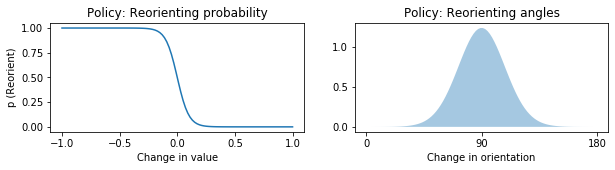

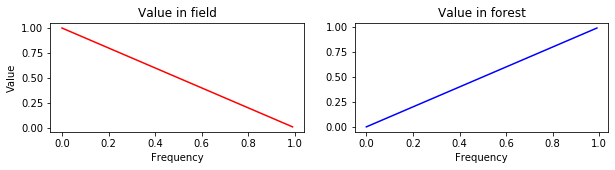

In [14]:
### Create a bee with known, context dependent value function weights 'w'
bee = createBee(params = {'valueFuncType': 'linear','policyFuncType': 'cw',
                           'softmaxTemp':20,'softmaxThreshold':0,
                           'reorientMu':np.pi/2, 'reorientKappa':10,'stepSize':0.5,
                           'discountGamma':0,'learningRate':0,
                           'w':{'forest': np.array([0,1]), 'field':np.array([1,-1])}})


# Plot policy functions - reorienting probability & angles
fig1 = plt.figure(figsize=(10, 2))
plt.subplot(121,title = 'Policy: Reorienting probability')
plt.plot(np.linspace(-1,1,100),1/(1+np.exp(bee.params['softmaxTemp']*(np.linspace(-1,1,100)-bee.params['softmaxThreshold']))))
plt.xlabel('Change in value')
plt.ylabel('p (Reorient)')

plt.subplot(122,title = 'Policy: Reorienting angles')
plt.fill(np.linspace(0,np.pi,100),ss.vonmises.pdf(np.linspace(0,np.pi,100),bee.params['reorientKappa'],loc = bee.params['reorientMu']),alpha = 0.4)
plt.xticks([0,np.pi/2,np.pi],[0,90,180])
plt.xlabel('Change in orientation')

# Plot value functions (assumed known)
fig2 = plt.figure(figsize=(10, 2))
plt.subplot(121,title = 'Value in field')
plt.plot(f,bee.valueFunc(f,'field'),color = 'r')
plt.ylabel('Value')
plt.xlabel('Frequency')
plt.subplot(122,title = 'Value in forest')
plt.plot(f,bee.valueFunc(f,'forest'),color = 'b')
plt.xlabel('Frequency')
plt.show()


Let's simulate the behavior of the bee on the patch for a single trial with 20 timesteps, in both contexts

<IPython.core.display.Javascript object>


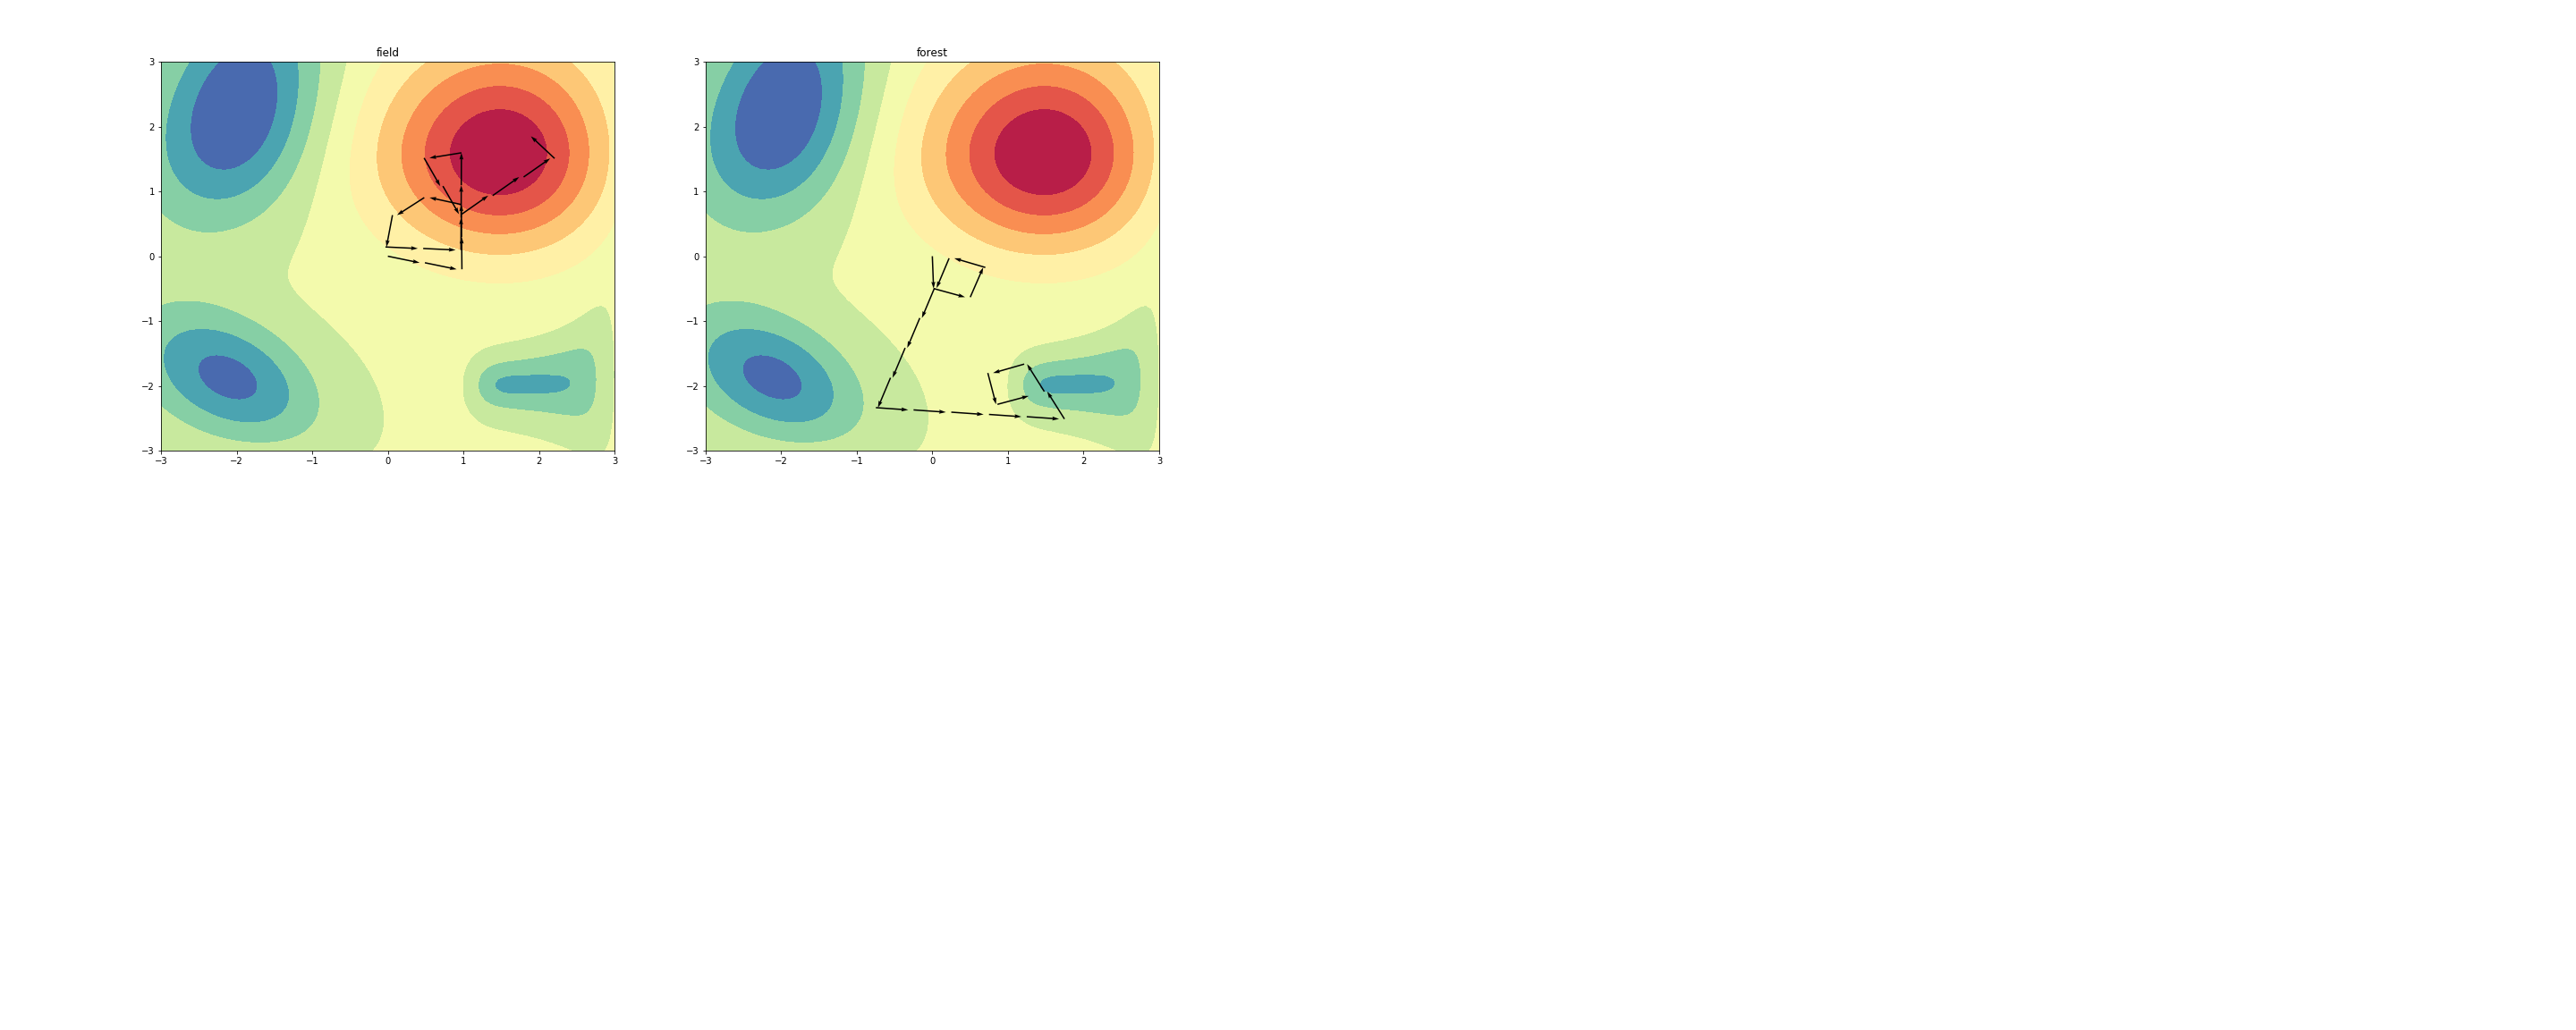

In [15]:
### Simulate 1 repetition of 20 timesteps - try setting thetaInit to various values (radians)
simPars = {'nReps':1,'tMax':20, 'thetaInit': np.random.vonmises(0,0.1)}

# Simulate foraging behavior
%matplotlib notebook
plt.ion()
#Loop over contexts
fig = plt.figure(figsize=(20, 8))
for context in {'field','forest'}:
    if context=='field':
        ax = plt.subplot(121)
    else:
        ax = plt.subplot(122)
    #Loop over repetitions
    for rep in np.arange(simPars['nReps']):
        # Plot patch environment
        plt.cla()
        plt.contourf(patch.X,patch.Y,patch.F,levels=10,cmap=plt.cm.get_cmap('Spectral'))
        plt.title(context)
    
        # Initial location
        xCurr = 0
        yCurr = 0
        # Initial orientation i.e. prospective location
        theta = simPars['thetaInit']
        xNext = xCurr + bee.params['stepSize']*np.cos(theta)
        yNext = yCurr + bee.params['stepSize']*np.sin(theta)
        # Initial, prospective frequencies
        fCurr, fNext = patch.f(xCurr,yCurr,xNext,yNext)
        
        #Loop over timesteps
        for t in np.arange(1,simPars['tMax']):
            
            #Planning: Compute expected value at current, prospective location
            vCurr = bee.valueFunc(fCurr,context)
            vNext = bee.valueFunc(fNext,context)
            
            #Action selection: Choose to continue/reorient based on policy, replanning as needed
            plan = 1
            while plan:
                #Current location
                xPrev = xCurr
                yPrev = yCurr
                
                #New angle
                deltaTheta = bee.policyFunc(vCurr,vNext)
                theta = theta + deltaTheta
                #New location
                xCurr = xPrev + bee.params['stepSize']*np.cos(theta)
                yCurr = yPrev + bee.params['stepSize']*np.sin(theta)
                #New orientation i.e. prospective location
                xNext = xCurr + bee.params['stepSize']*np.cos(theta)
                yNext = yCurr + bee.params['stepSize']*np.sin(theta)
                
                if xNext>np.min(patch.X) and yNext>np.min(patch.Y) and xNext<np.max(patch.X) and yNext<np.max(patch.Y):
                    #New flower frequencies
                    fCurr, fNext = patch.f(xCurr,yCurr,xNext,yNext)
                    plan = 0
                else:

                #Replan if boundary encountered in current/prospective location
                    plan = 1
                    xCurr = xPrev
                    yCurr = yPrev
                    vNext = -np.inf
                    
            #Plot movement to new location
            ax.quiver(xPrev,yPrev,xCurr-xPrev, yCurr-yPrev,scale = 7,width = 0.003)
            fig.canvas.draw()
plt.show()
%matplotlib inline

## Learning values with TD learning

We now turn to the problem of learning the value function, i.e. updating the weights based on reward feedback. As a reminder, we will do this using Temporal Difference learning

<IPython.core.display.Javascript object>


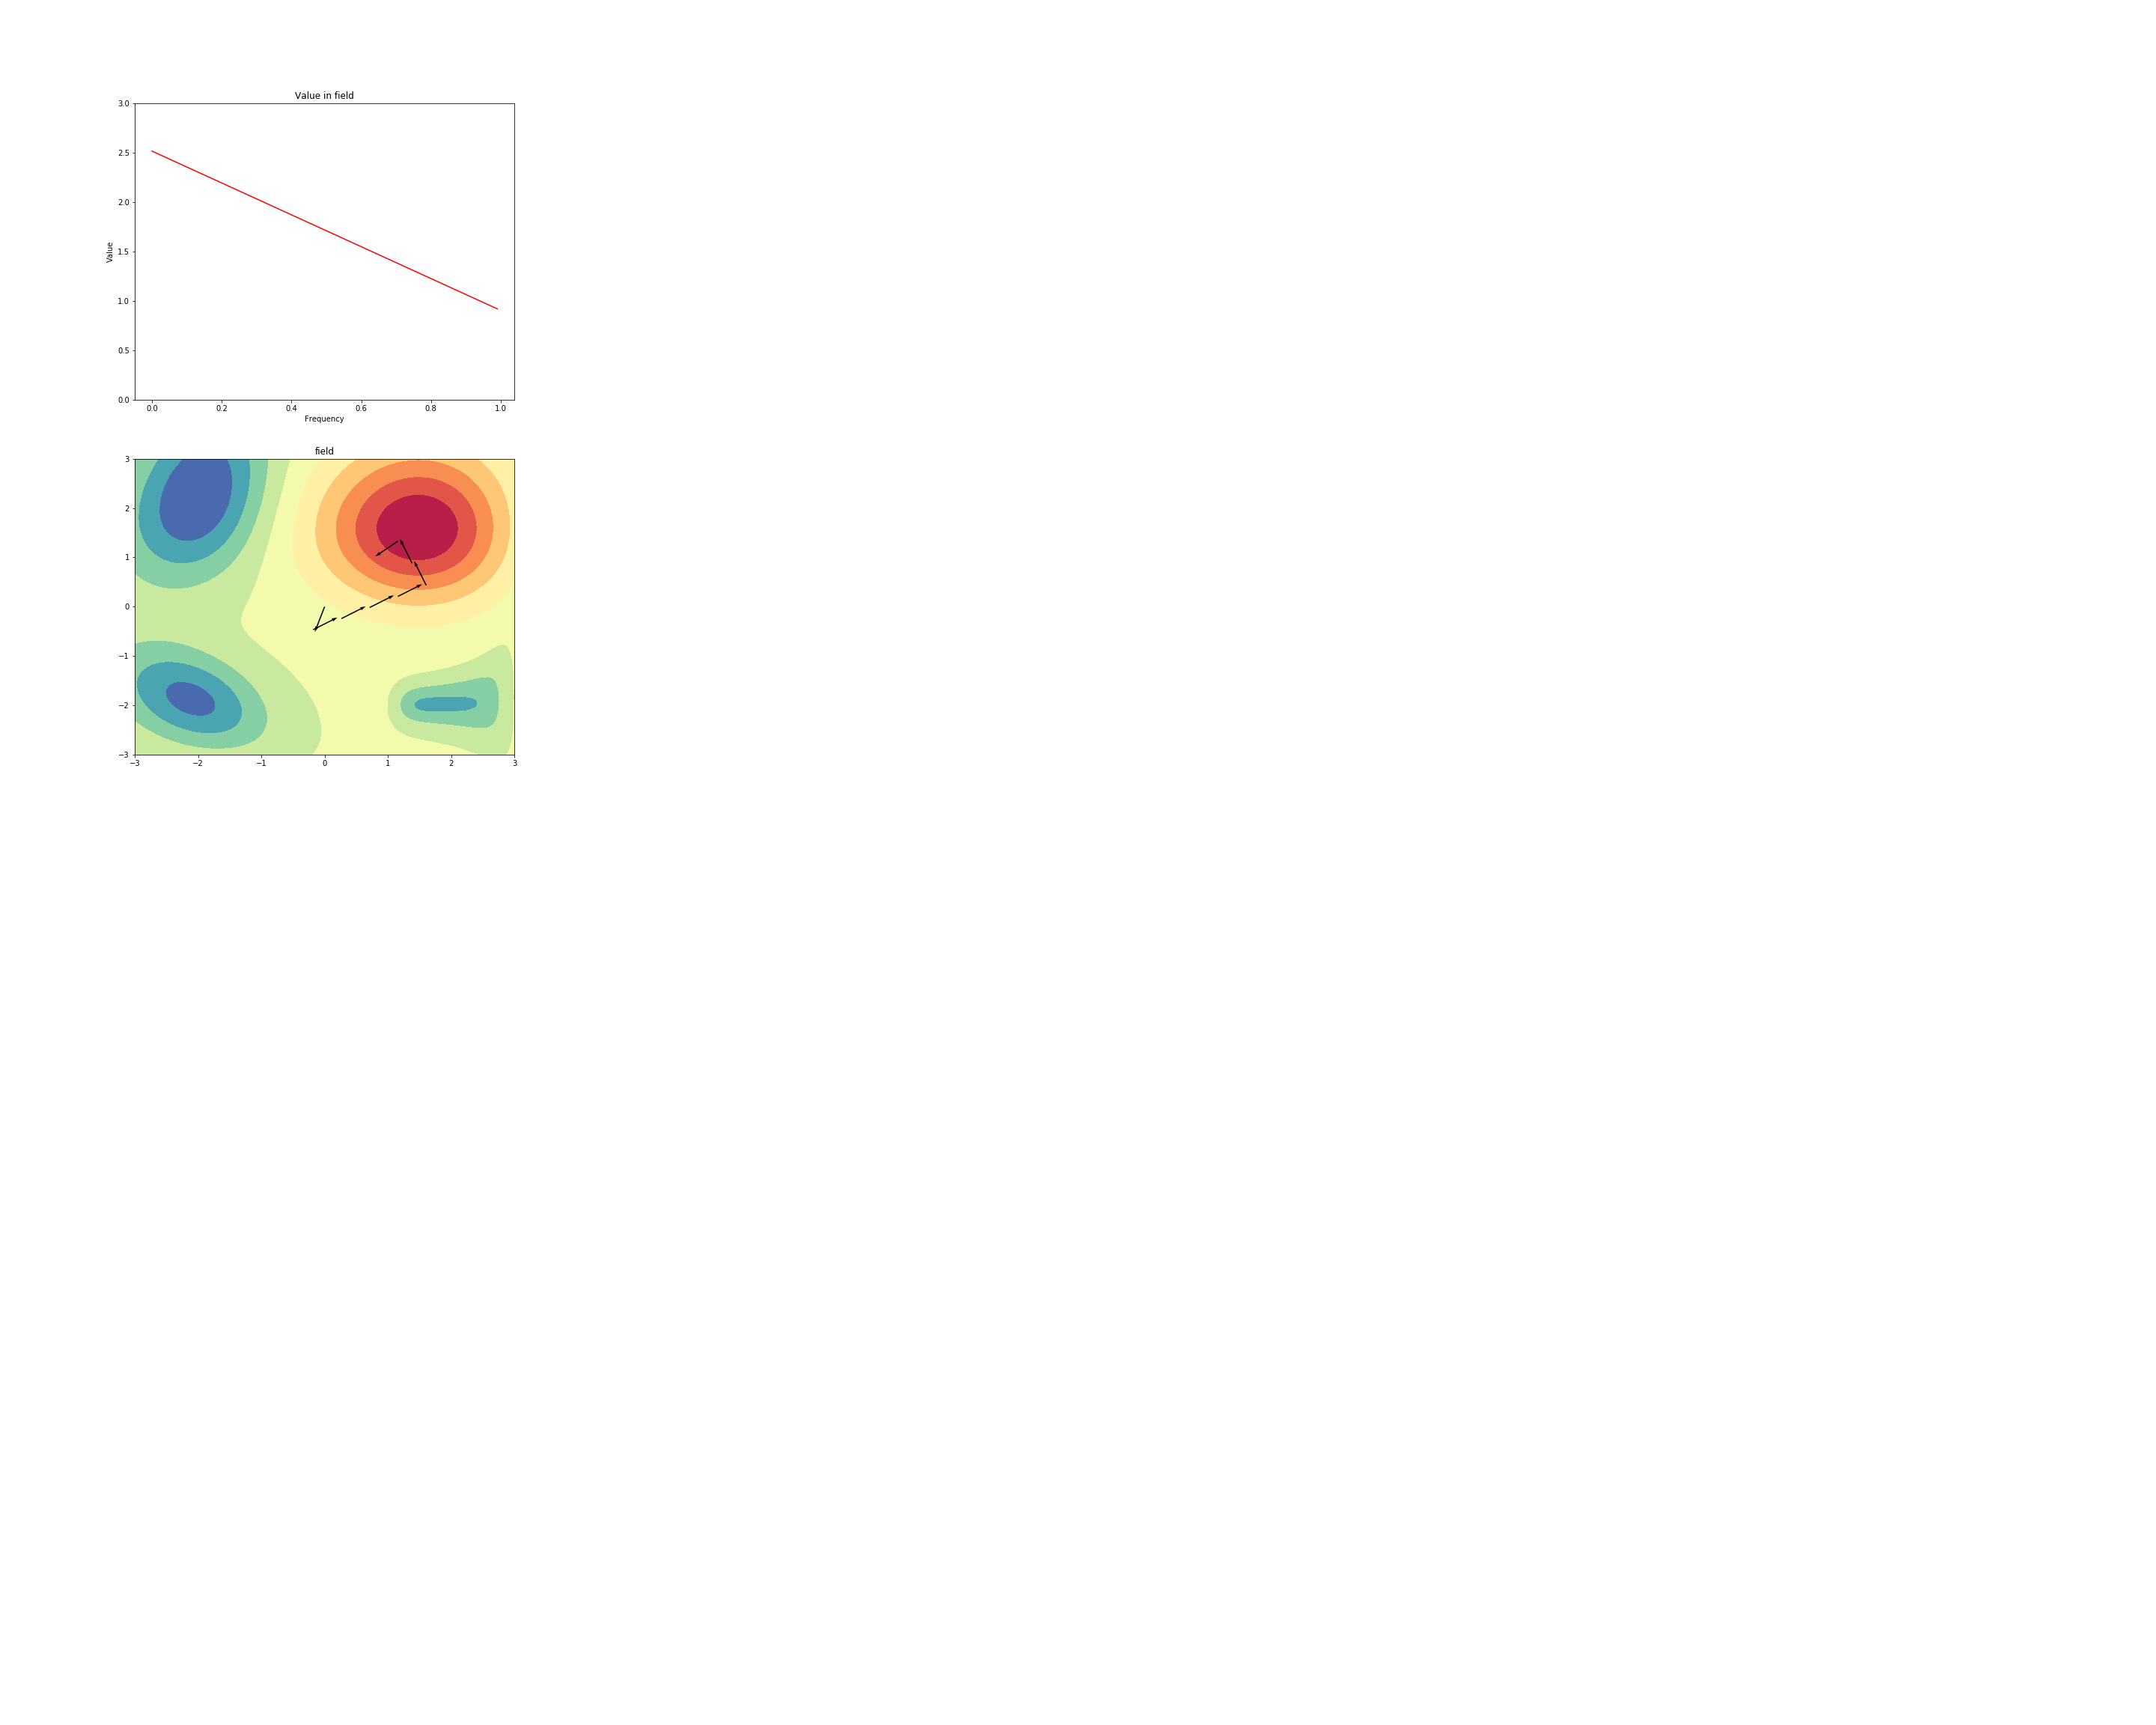

In [ ]:
### Create a bee with unknown, context dependent weights 'w' - initialized to 0
bee = createBee(params = {'valueFuncType': 'linear','policyFuncType': 'cw',
                           'softmaxTemp':20,'softmaxThreshold':0,
                           'reorientMu':np.pi/2, 'reorientKappa':10,'stepSize':0.5,
                           'discountGamma':0.6,'learningRate':0.5,
                           'w':{'forest': np.array([0,0]), 'field':np.array([0, 0])}})

### Simulate 20 repetitions of 20 timesteps - alternatively simulate 1 repetition of 200 timesteps
simPars = {'nReps':20,'tMax':20, 'thetaInit': np.random.vonmises(0,0.1)}


%matplotlib notebook
fig = plt.figure(figsize=(20, 16))
plt.ion()

# Simulate foraging behavior
#Loop over contexts
for context in {'field','forest'}:
    # Plot initial weights
    if context=='field':
        axv1 = plt.subplot(221,title = 'Value in field')
        plt.plot(f,bee.valueFunc(f,'field'),color = 'r')
        plt.ylabel('Value')
        plt.xlabel('Frequency')
        axp1 = plt.subplot(223)
    else:
        axv2 = plt.subplot(222,title = 'Value in forest')
        plt.plot(f,bee.valueFunc(f,'forest'),color = 'b')
        plt.xlabel('Frequency')
        plt.ylabel('Value')
        axp2 = plt.subplot(224)
    
    #Loop over repetitions
    for rep in np.arange(simPars['nReps']):

        # Plot patch environment
        if context=='field':
            plt.sca(axp1)
        else:
            plt.sca(axp2)
        plt.cla()
        plt.contourf(patch.X,patch.Y,patch.F,levels=10,cmap=plt.cm.get_cmap('Spectral'))
        plt.title(context)
    
        # Initial location
        xCurr = 0
        yCurr = 0
        # Initial orientation i.e. prospective location
        theta = simPars['thetaInit']
        xNext = xCurr + bee.params['stepSize']*np.cos(theta)
        yNext = yCurr + bee.params['stepSize']*np.sin(theta)
        # Initial, prospective frequencies
        fCurr, fNext = patch.f(xCurr,yCurr,xNext,yNext)
        
        #Loop over timesteps
        for t in np.arange(1,simPars['tMax']):
            
            #Planning: Compute expected value at current, prospective location
            vCurr = bee.valueFunc(fCurr,context)
            vNext = bee.valueFunc(fNext,context)
            
            #Action selection: Choose to continue/reorient based on policy, replanning as needed
            plan = 1
            while plan:
                #Current location
                xPrev = xCurr
                yPrev = yCurr
                
                #New angle
                deltaTheta = bee.policyFunc(vCurr,vNext)
                theta = theta + deltaTheta
                #New location
                xCurr = xPrev + bee.params['stepSize']*np.cos(theta)
                yCurr = yPrev + bee.params['stepSize']*np.sin(theta)
                #New orientation i.e. prospective location
                xNext = xCurr + bee.params['stepSize']*np.cos(theta)
                yNext = yCurr + bee.params['stepSize']*np.sin(theta)
                
                if xNext>np.min(patch.X) and yNext>np.min(patch.Y) and xNext<np.max(patch.X) and yNext<np.max(patch.Y):
                    #New flower frequencies
                    fCurr, fNext = patch.f(xCurr,yCurr,xNext,yNext)
                    plan = 0
                else:

                #Replan if boundary encountered in current/prospective location
                    plan = 1
                    xCurr = xPrev
                    yCurr = yPrev
                    vNext = -np.inf
                    
            #Plot movement to new location
            if context =='field':
                axp1.quiver(xPrev,yPrev,xCurr-xPrev, yCurr-yPrev,scale = 7,width = 0.003)
            else:
                axp2.quiver(xPrev,yPrev,xCurr-xPrev, yCurr-yPrev,scale = 7,width = 0.003)
            
            #Observe sensory outcome of action, re-evaluate current, prospective location
            vCurr = bee.valueFunc(fCurr,context)
            vNext = bee.valueFunc(fNext,context)
            
            #Observe reward outcome of action, update weights based on learning rule
            reward = patch.nectar(fCurr,context)
            bee.learningFunc(fCurr,context,vCurr,vNext,reward)
            
            # Plot updated weights
            if context == 'field':
                plt.sca(axv1)
                plt.cla()
                plt.plot(f,bee.valueFunc(f,context),color = 'r')
            else:
                plt.sca(axv2)
                plt.cla()
                plt.plot(f,bee.valueFunc(f,context),color = 'b')
            plt.ylabel('Value')
            plt.xlabel('Frequency')
            plt.title('Value in '+context)
            plt.ylim(0,3)

            fig.canvas.draw()
%matplotlib inline
plt.show()